# Passive Learning (Manual)

## 1. Data Preprocessing

In [4]:
# Birth-Death Record Linkage Analysis
# A comprehensive record linkage system for linking birth and death records

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from datasketch import MinHash, MinHashLSH
# from jellyfish import jaro_winkler, damerau_levenshtein_distance
from jellyfish import jaro_similarity, jaro_winkler_similarity, levenshtein_distance, damerau_levenshtein_distance
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("Birth-Death Record Linkage System")
print("=" * 50)

# %% [markdown]
# ## Step 1: Data Preprocessing


# %%
# Load the datasets
print("Loading datasets...")

# clean data (500k)
birth_df = pd.read_csv('../linkage data/data_500k/clean/birth_records.csv')
death_df = pd.read_csv('../linkage data/data_500k/clean/death_records.csv')

print(f"Birth records: {birth_df.shape[0]} rows, {birth_df.shape[1]} columns")
print(f"Death records: {death_df.shape[0]} rows, {death_df.shape[1]} columns")

# %%
# Examine the structure of both datasets
print("\nBirth Records Columns:")
print(birth_df.columns.tolist())
print(f"\nDeath Records Columns:")
print(death_df.columns.tolist())

# %%
# Check for missing values
print("\nMissing values in Birth Records:")
print(birth_df.isnull().sum().head(10))
print(f"\nMissing values in Death Records:")
print(death_df.isnull().sum().head(10))

# %%
# Data preprocessing - select relevant columns for linkage
birth_columns = [
    'ID', 'child\'s forname(s)', 'child\'s surname', 'sex', 
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'birth year', 'address', 'Death'
]

death_columns = [
    'ID', 'forename(s) of deceased', 'surname of deceased', 'sex',
    'father\'s forename', 'father\'s surname', 'father\'s occupation',
    'mother\'s forename', 'mother\'s maiden surname', 'mother\'s occupation',
    'year', 'address', 'age at death'
]

# Create clean datasets
birth_clean = birth_df[birth_columns].copy()
death_clean = death_df[death_columns].copy()

# Rename columns for consistency
birth_clean.columns = ['birth_id', 'forename', 'surname', 'sex', 
                       'father_forename', 'father_surname', 'father_occupation',
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'birth_year', 'address', 'death_link']

death_clean.columns = ['death_id', 'forename', 'surname', 'sex',
                       'father_forename', 'father_surname', 'father_occupation', 
                       'mother_forename', 'mother_surname', 'mother_occupation',
                       'death_year', 'address', 'age_at_death']

# Fill missing values with empty strings for string columns
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'father_occupation', 'mother_forename', 'mother_surname', 
               'mother_occupation', 'address']

for col in string_cols:
    birth_clean[col] = birth_clean[col].fillna('').astype(str)
    death_clean[col] = death_clean[col].fillna('').astype(str)

print(f"\nCleaned Birth Records: {birth_clean.shape}")
print(f"Cleaned Death Records: {death_clean.shape}")


Birth-Death Record Linkage System
Loading datasets...
Birth records: 1297360 rows, 39 columns
Death records: 1297360 rows, 38 columns

Birth Records Columns:
['ID', 'family', 'marriage', "child's forname(s)", "child's surname", 'birth day', 'birth month', 'birth year', 'address', 'sex', "father's forename", "father's surname", "father's occupation", "mother's forename", "mother's maiden surname", "mother's occupation", "day of parents' marriage", "month of parents' marriage", "year of parents' marriage", "place of parent's marriage", 'illegit', 'notes', 'Death', 'CHILD_IDENTITY', 'MOTHER_IDENTITY', 'FATHER_IDENTITY', 'DEATH_RECORD_IDENTITY', 'PARENT_MARRIAGE_RECORD_IDENTITY', 'FATHER_BIRTH_RECORD_IDENTITY', 'MOTHER_BIRTH_RECORD_IDENTITY', 'MARRIAGE_RECORD_IDENTITY1', 'MARRIAGE_RECORD_IDENTITY2', 'MARRIAGE_RECORD_IDENTITY3', 'MARRIAGE_RECORD_IDENTITY4', 'MARRIAGE_RECORD_IDENTITY5', 'MARRIAGE_RECORD_IDENTITY6', 'MARRIAGE_RECORD_IDENTITY7', 'MARRIAGE_RECORD_IDENTITY8', 'IMMIGRANT_GENERATI

### Ground-truth function
- can adjust the `data_size`

In [5]:

# Sample both datasets to XX rows
data_size = 1500000 # go with the max size = 1.3 M rows
# data_size = 300000
print(f"Sampling datasets to {data_size} rows each...")
print("=" * 40)

# Original sizes
print(f"Original birth records: {len(birth_clean):,}")
print(f"Original death records: {len(death_clean):,}")

# Sample birth records to XX rows
birth_sample_size = min(data_size, len(birth_clean))
birth_sampled = birth_clean.sample(n=birth_sample_size, random_state=42).reset_index(drop=True)

# Sample death records to XX rows  
death_sample_size = min(data_size, len(death_clean))
death_sampled = death_clean.sample(n=death_sample_size, random_state=42).reset_index(drop=True)

print(f"Sampled birth records: {len(birth_sampled):,}")
print(f"Sampled death records: {len(death_sampled):,}")
print(f"Total pairs to create: {len(birth_sampled) * len(death_sampled):,}")

# Use sampled data for ground truth
birth_clean = birth_sampled
death_clean = death_sampled

print("Sampling completed!")
print()

def create_efficient_ground_truth(birth_df, death_df):
    ground_truth = []
    
    # Create death_id lookup for validation
    valid_death_ids = set(death_df['death_id'].values)
    
    for _, birth_row in birth_df.iterrows():
        birth_id = birth_row['birth_id']
        death_link = birth_row['death_link']
        
        # Only process records with valid death links
        if pd.notna(death_link):
            # Verify the death_id exists in birth records
            if death_link in valid_death_ids:
                ground_truth.append({
                    'birth_id': birth_id,
                    'death_id': death_link,
                    'label': 1  # Confirmed match
                })
    
    return pd.DataFrame(ground_truth)


ground_truth_df = create_efficient_ground_truth(birth_clean, death_clean)

print(f"\nGround truth created: {len(ground_truth_df)} record pairs")
print(f"Positive matches: {ground_truth_df['label'].sum()}")
print(f"Negative matches: {len(ground_truth_df) - ground_truth_df['label'].sum()}")


Sampling datasets to 1500000 rows each...
Original birth records: 1,297,360
Original death records: 1,297,360
Sampled birth records: 1,297,360
Sampled death records: 1,297,360
Total pairs to create: 1,683,142,969,600
Sampling completed!


Ground truth created: 1297360 record pairs
Positive matches: 1297360
Negative matches: 0


In [6]:
# ground_truth_df.loc[ground_truth_df['label'] == 1]
print(ground_truth_df)
print(ground_truth_df.loc[ground_truth_df['label'] == 1])

         birth_id  death_id  label
0         2126241   2126241      1
1          963232    963232      1
2          944415    944415      1
3         2190464   2190464      1
4         1276997   1276997      1
...           ...       ...    ...
1297355   1055012   1055012      1
1297356   1456888   1456888      1
1297357   1134408   1134408      1
1297358    815135    815135      1
1297359   1102958   1102958      1

[1297360 rows x 3 columns]
         birth_id  death_id  label
0         2126241   2126241      1
1          963232    963232      1
2          944415    944415      1
3         2190464   2190464      1
4         1276997   1276997      1
...           ...       ...    ...
1297355   1055012   1055012      1
1297356   1456888   1456888      1
1297357   1134408   1134408      1
1297358    815135    815135      1
1297359   1102958   1102958      1

[1297360 rows x 3 columns]


## 2. Indexing (Blocking)

In [7]:
def create_minhash_signature(record, columns):
    """Create MinHash signature for a record"""
    minhash = MinHash()  
    for col in columns:
        data = str(record[col]).lower()
        for token in data.split():
            minhash.update(token.encode('utf8'))
    return minhash

def blocking_with_minhash(birth_df, death_df, threshold):
    """Create blocks using MinHash LSH"""
    print(f"Creating blocks with threshold: {threshold}")
    
    # Columns to use for blocking
    blocking_cols = ['forename', 'surname', 'father_surname', 'mother_surname']
    
    # Create MinHash signatures for all records
    birth_signatures = {}
    death_signatures = {}
    
    print("Creating MinHash signatures for birth records...")
    for idx, row in birth_df.iterrows():
        birth_signatures[f"birth_{row['birth_id']}"] = create_minhash_signature(row, blocking_cols)
    
    print("Creating MinHash signatures for death records...")
    for idx, row in death_df.iterrows():
        death_signatures[f"death_{row['death_id']}"] = create_minhash_signature(row, blocking_cols)
    
    # Create LSH index
    lsh = MinHashLSH(threshold=threshold)
    
    # Insert all signatures
    print("Inserting signatures into LSH index...")
    for key, sig in birth_signatures.items():
        lsh.insert(key, sig)
    for key, sig in death_signatures.items():
        lsh.insert(key, sig)
    
    # Generate candidate pairs and detailed blocking information
    candidate_pairs = []
    birth_blocks = {}  # Dictionary to store blocks for each birth record, only for the illustration
    
    print("Generating candidate pairs...")
    for birth_key, birth_sig in birth_signatures.items():
        similar_records = lsh.query(birth_sig)
        birth_id = int(birth_key.split('_')[1])
        
        # Find death records in the same block
        death_records_in_block = []
        for similar_key in similar_records:
            if similar_key.startswith('death_'):
                death_id = int(similar_key.split('_')[1])
                candidate_pairs.append((birth_id, death_id))
                death_records_in_block.append(death_id)
        
        # Store block information (just for statistical purposes)
        birth_blocks[birth_id] = {
            'birth_id': birth_id,
            'death_records': death_records_in_block,
            'total_similar_records': len(similar_records),
            'death_count': len(death_records_in_block)
        }
    
    # Remove duplicates from candidate pairs
    candidate_pairs = list(set(candidate_pairs))
    
    print(f"Generated {len(candidate_pairs)} candidate pairs") # for computation
    print(f"Generated {len(birth_blocks)} birth blocks") # for illustration, exploration
    
    return candidate_pairs, birth_blocks

# Generate candidate pairs through blocking
candidate_pairs, birth_blocks = blocking_with_minhash(birth_clean, death_clean, threshold=0.7)


Creating blocks with threshold: 0.7
Creating MinHash signatures for birth records...
Creating MinHash signatures for death records...
Inserting signatures into LSH index...
Generating candidate pairs...
Generated 4733394 candidate pairs
Generated 1297360 birth blocks


- checking the candidate pair that is same with the birth_blocks variable
- the diff is only the data types
- And, birth_blocks count the one that dont have the death (candidate)

In [8]:
def checking_candidate_pairs_by_ID(checking_id):
    r = []
    for i in range(len(candidate_pairs)):
        if candidate_pairs[i][0] == checking_id:
            r.append(candidate_pairs[i])
    print(f"\nCandidate pairs for birth ID {checking_id}: {r}")
    print(f"Total candidate pairs for birth ID {checking_id}: {len(r)}")

checking_candidate_pairs_by_ID(checking_id=1383518)
checking_candidate_pairs_by_ID(checking_id=2532606)
checking_candidate_pairs_by_ID(checking_id=1276997)




Candidate pairs for birth ID 1383518: [(1383518, 1383518), (1383518, 1460159), (1383518, 1590449), (1383518, 1481421), (1383518, 1559160), (1383518, 1444057), (1383518, 1617196), (1383518, 2076513), (1383518, 1370469), (1383518, 1381013), (1383518, 2035357), (1383518, 1499736), (1383518, 1644270), (1383518, 1832364)]
Total candidate pairs for birth ID 1383518: 14

Candidate pairs for birth ID 2532606: [(2532606, 802372), (2532606, 1701402), (2532606, 1616808), (2532606, 1711340), (2532606, 1725404), (2532606, 1709246), (2532606, 1799246), (2532606, 1577638), (2532606, 2109078), (2532606, 1645888), (2532606, 1775264), (2532606, 3141996), (2532606, 1609238), (2532606, 1434316), (2532606, 1954920), (2532606, 1449998), (2532606, 1545264), (2532606, 1618232), (2532606, 1697642), (2532606, 1603008), (2532606, 1105744), (2532606, 1854758), (2532606, 922568), (2532606, 2388626), (2532606, 1399976), (2532606, 2663886), (2532606, 2532606), (2532606, 1104980), (2532606, 1699270), (2532606, 15768

### Blocking Statistics


Detailed Blocking Analysis:
Sample Blocks (First 15 Birth Records):
----------------------------------------
Block 1:
  Birth ID: 2126241
  Associated Death Records: [2126241]
  Number of Death Records: 1
  Birth Record: Ieuan Blair
  Death Record(s):
    ID 2126241: Ieuan Blair
---
Block 2:
  Birth ID: 963232
  Associated Death Records: [963232]
  Number of Death Records: 1
  Birth Record: Frances Logan
  Death Record(s):
    ID 963232: Frances Logan
---
Block 3:
  Birth ID: 944415
  Associated Death Records: [944415]
  Number of Death Records: 1
  Birth Record: Christopher Maclachlan
  Death Record(s):
    ID 944415: Christopher Maclachlan
---
Block 4:
  Birth ID: 2190464
  Associated Death Records: [2190464, 3040230]
  Number of Death Records: 2
  Birth Record: Megan Sutherland
  Death Record(s):
    ID 2190464: Megan Sutherland
    ID 3040230: Megan Wilkie
---
Block 5:
  Birth ID: 1276997
  Associated Death Records: [2446049, 2386014, 1347017, 1276997, 1264946, 1537476]
  Number o

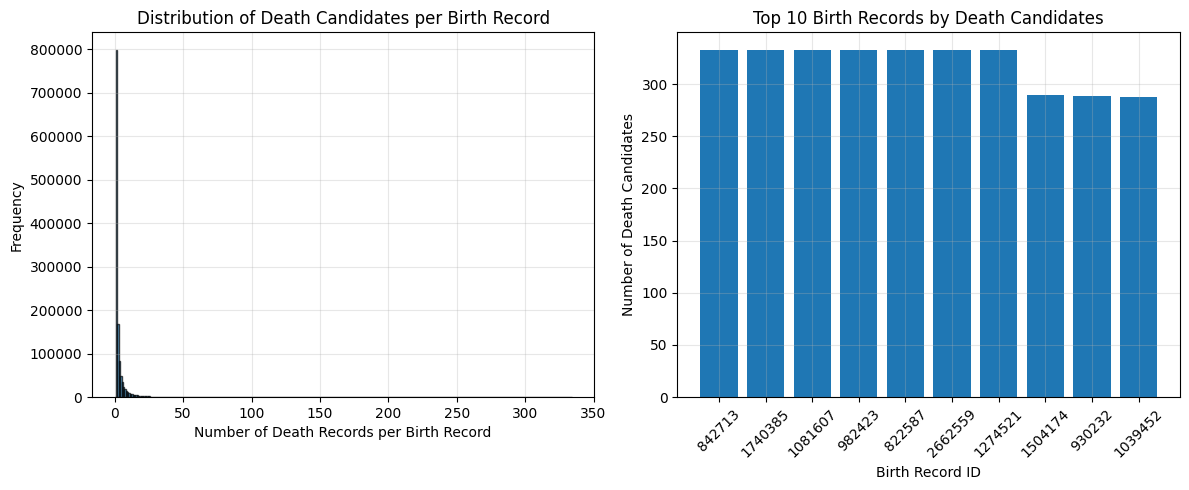


Birth Records with Multiple Death Candidates:
--------------------------------------------------
Found 497948 birth records with multiple death candidates:

Birth ID 842713: Joshua Smith
  Death candidates (333):
    ID 1910143: Joshua Smith (Age: 0)
    ID 702633: Liban Macleod (Age: 71)
    ID 738223: Jamie Thomson (Age: 66)
    ID 1523062: Simone Robb (Age: 49)
    ID 1302458: Kirran Thomson (Age: 81)
    ID 2226555: Kieron Graham (Age: 51)
    ID 669634: Amy Thomson (Age: 75)
    ID 869421: Kaashif Thomson (Age: 52)
    ID 1274679: Joshua Watson (Age: 32)
    ID 1220218: Amy Thomson (Age: 49)
    ID 900777: Joshua Smith (Age: 50)
    ID 1900375: Sebastian Thomson (Age: 57)
    ID 974763: Joshua Smith (Age: 76)
    ID 1525118: Amy Thomson (Age: 59)
    ID 695685: Joshua Scott (Age: 81)
    ID 2278717: Joshua Reynolds (Age: 35)
    ID 2405971: Zayd Thomson (Age: 17)
    ID 1548285: Hamza Thomson (Age: 40)
    ID 657380: Rosie Mcdonald (Age: 85)
    ID 1637566: Isobel Thomson (Age: 8

In [9]:
# Show detailed blocking results
print("\nDetailed Blocking Analysis:")
print("=" * 50)

# Show first 15 birth records and their associated death records
print("Sample Blocks (First 15 Birth Records):")
print("-" * 40)

birth_ids_sample = list(birth_blocks.keys())[:15]
for i, birth_id in enumerate(birth_ids_sample):
    block_info = birth_blocks[birth_id]
    print(f"Block {i+1}:")
    print(f"  Birth ID: {birth_id}")
    print(f"  Associated Death Records: {block_info['death_records']}")
    print(f"  Number of Death Records: {block_info['death_count']}")
    # print(f"  Total Similar Records: {block_info['total_similar_records']}")
    
    # Show names for context
    birth_record = birth_clean[birth_clean['birth_id'] == birth_id].iloc[0]
    print(f"  Birth Record: {birth_record['forename']} {birth_record['surname']}")
    
    if block_info['death_records']:
        print(f"  Death Record(s):")
        for death_id in block_info['death_records']:
            death_record = death_clean[death_clean['death_id'] == death_id]
            if not death_record.empty:
                death_record = death_record.iloc[0]
                print(f"    ID {death_id}: {death_record['forename']} {death_record['surname']}")
    else:
        print(f"  No death records in this block")
    print("---")

# %%
# Statistical analysis of blocking results
print(f"\nBlocking Statistics:")
print("=" * 30)

death_counts = [block_info['death_count'] for block_info in birth_blocks.values()]
birth_records_with_deaths = sum(1 for count in death_counts if count > 0)
birth_records_without_deaths = sum(1 for count in death_counts if count == 0)

print(f"Total birth records: {len(birth_blocks)}")
print(f"Birth records with death candidates: {birth_records_with_deaths}")
print(f"Birth records without death candidates: {birth_records_without_deaths}")
print(f"Average death candidates per birth record: {np.mean(death_counts):.2f}")
print(f"Max death candidates for a single birth record: {max(death_counts)}")

# %%
# Distribution of death record counts per birth record
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(death_counts, bins=range(max(death_counts)+2), alpha=0.7, edgecolor='black')
plt.xlabel('Number of Death Records per Birth Record')
plt.ylabel('Frequency')
plt.title('Distribution of Death Candidates per Birth Record')
plt.grid(True, alpha=0.3)

# Show birth records with most death candidates
plt.subplot(1, 2, 2)
top_candidates = sorted(birth_blocks.items(), key=lambda x: x[1]['death_count'], reverse=True)[:10]
birth_ids = [str(item[0]) for item in top_candidates]
death_counts_top = [item[1]['death_count'] for item in top_candidates]

plt.bar(birth_ids, death_counts_top)
plt.xlabel('Birth Record ID')
plt.ylabel('Number of Death Candidates')
plt.title('Top 10 Birth Records by Death Candidates')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# %%
# Show birth records with multiple death candidates
print(f"\nBirth Records with Multiple Death Candidates:")
print("-" * 50)

multiple_candidates = {birth_id: info for birth_id, info in birth_blocks.items() 
                      if info['death_count'] > 1}

if multiple_candidates:
    print(f"Found {len(multiple_candidates)} birth records with multiple death candidates:")
    
    for birth_id, block_info in sorted(multiple_candidates.items(), 
                                      key=lambda x: x[1]['death_count'], reverse=True)[:10]:
        birth_record = birth_clean[birth_clean['birth_id'] == birth_id].iloc[0]
        print(f"\nBirth ID {birth_id}: {birth_record['forename']} {birth_record['surname']}")
        print(f"  Death candidates ({block_info['death_count']}):")
        
        for death_id in block_info['death_records']:
            death_record = death_clean[death_clean['death_id'] == death_id]
            if not death_record.empty:
                death_record = death_record.iloc[0]
                print(f"    ID {death_id}: {death_record['forename']} {death_record['surname']} "
                      f"(Age: {death_record['age_at_death']})")
else:
    print("No birth records have multiple death candidates with this threshold.")

# %%
# Summary table
print(f"\nBlocking Summary Table:")
print("=" * 25)

summary_data = []
for count in range(max(death_counts) + 1):
    freq = death_counts.count(count)
    percentage = (freq / len(death_counts)) * 100
    summary_data.append({
        'Death_Candidates': count,
        'Birth_Records': freq,
        'Percentage': f"{percentage:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))


## 3. Comparing
### Feature
- from append()
- these are the features in each columns
1. jaro winkler
2. damerau levenshtein
3. jaccard similarity
4. age consistency 

In [10]:

# %% [markdown]
# ## Step 3: Comparing (Feature Engineering)

# %%
def jaccard_similarity(str1, str2):
    """Calculate Jaccard similarity between two strings"""
    set1 = set(str1.lower().split())
    set2 = set(str2.lower().split())
    if len(set1.union(set2)) == 0:
        return 0
    return len(set1.intersection(set2)) / len(set1.union(set2))

def calculate_features(birth_record, death_record):
    """Calculate similarity features between two records"""
    features = []
    
    # String comparison columns
    string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
                   'mother_forename', 'mother_surname', 'address']
    
    for col in string_cols:
        birth_val = str(birth_record[col]).lower()
        death_val = str(death_record[col]).lower()
        
        # Jaro-Winkler similarity
        jw_sim = jaro_winkler_similarity(birth_val, death_val)
        features.append(jw_sim)
        # features.append({'col': col, 'jw_sim': jw_sim})
        
        # Damerau-Levenshtein distance (normalized)
        dl_dist = damerau_levenshtein_distance(birth_val, death_val)
        max_len = max(len(birth_val), len(death_val))
        dl_sim = 1 - (dl_dist / max_len) if max_len > 0 else 1
        features.append(dl_sim)
        # features.append({'col': col, 'dl_sim': dl_sim})
        
        # Jaccard similarity
        jaccard_sim = jaccard_similarity(birth_val, death_val)
        features.append(jaccard_sim)
        # features.append({'col': col, 'jaccard_sim': jaccard_sim})

    try:
        # Convert to numeric, handling potential string inputs
        birth_year = pd.to_numeric(birth_record['birth_year'], errors='coerce')
        death_year = pd.to_numeric(death_record['death_year'], errors='coerce')  
        age_at_death = pd.to_numeric(death_record['age_at_death'], errors='coerce')
        
        if pd.notna(birth_year) and pd.notna(death_year) and pd.notna(age_at_death):
            expected_birth_year = death_year - age_at_death
            age_diff = abs(birth_year - expected_birth_year)
            age_consistency = 1 / (1 + age_diff)  # Exponential decay
            # features.append({'col': 'age_consistency', 'value': age_consistency})
            features.append(age_consistency)
        else:
            # features.append({'col': 'age_consistency', 'value': 0.5})
            features.append(0.5)
    except:
        # Fallback if conversion fails
        # features.append({'col': 'age_consistency', 'value': 0.5})
        features.append(0.5)
    
    return features

# Create feature matrix
print("Calculating features for candidate pairs...")
X = []
y = []
candidate_pairs_list = []

# Create lookup dictionaries for faster access
birth_lookup = {row['birth_id']: row for _, row in birth_clean.iterrows()} # death link
death_lookup = {row['death_id']: row for _, row in death_clean.iterrows()}
ground_truth_lookup = {(row['birth_id'], row['death_id']): row['label'] 
                      for _, row in ground_truth_df.iterrows()}

for birth_id, death_id in candidate_pairs: # use candidate pairs only
    if birth_id in birth_lookup and death_id in death_lookup:
        birth_record = birth_lookup[birth_id]
        death_record = death_lookup[death_id]
        
        features = calculate_features(birth_record, death_record)
        X.append(features)
        
        # Get ground truth label
        label = ground_truth_lookup.get((birth_id, death_id))
        label = int(label) if label is not None else 0  # Default to 0 if not found
        y.append(label)

        # Track the candidate pair for this feature row
        candidate_pairs_list.append((birth_id, death_id))

X = np.array(X)
y = np.array(y)  # Ensure labels are integers

print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")
# print(f"Positive class ratio: {np.sum(y)/len(y):.4f}")

print("Saving features and labels...")

# Option 1: Save as NumPy arrays (recommended for X, y)
np.save('X_features.npy', X)
np.save('y_labels.npy', y)

Calculating features for candidate pairs...
Feature matrix shape: (4733394, 25)
Labels shape: (4733394,)
Saving features and labels...


In [11]:
# y[0:20]
X[5]

array([0.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 0.        , 0.        , 0.        , 0.63333333,
       0.4       , 0.        , 1.        , 1.        , 1.        ,
       0.44761905, 0.14285714, 0.        , 0.48333333, 0.2       ,
       0.        , 0.55185185, 0.33333333, 0.        , 0.01176471])

In [12]:
y[:100]



array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1])

## 4. Classification
### Cross Validation (5 folds)
- with Metrics performance; Precision, Recall, F1
- draw Plots

In [13]:

# %%
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, random_state=42, stratify=y
# )

X_train, X_test, y_train, y_test, pairs_train, pairs_test = train_test_split(
    X, y, candidate_pairs_list, 
    test_size=0.3, random_state=42, stratify=y
)


## randomly select 100 candidate pairs for testing *****



print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Training positive ratio: {np.sum(y_train)/len(y_train):.4f}")
print(f"Test positive ratio: {np.sum(y_test)/len(y_test):.4f}")

# %%
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# %%
# Cross-Validation Analysis (on training data only)
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer

print("\nPerforming Cross-Validation Analysis (Training Data Only)...")
print("=" * 60)

# %%
# Check if we have enough samples for cross-validation
if len(np.unique(y_train)) < 2:
    print("Warning: Only one class present in the training data. Cannot perform classification.")
    print("This might indicate:")
    print("1. Threshold too high (try lowering it)")
    print("2. Ground truth issues")
    print("3. No actual matches in the candidate pairs")
    
    # Show class distribution
    unique_classes, counts = np.unique(y_train, return_counts=True)
    for cls, count in zip(unique_classes, counts):
        print(f"Class {cls}: {count} samples")
else:
    # Define custom scorers
    scoring = {
        'precision': make_scorer(precision_score, zero_division=0),
        'recall': make_scorer(recall_score, zero_division=0),
        'f1': make_scorer(f1_score, zero_division=0)
    }

    # %%
    # Perform 5-fold stratified cross-validation on training data only
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    print("5-Fold Stratified Cross-Validation Results (Training Data Only):")
    print("-" * 60)

    # Initialize classifier for CV
    rf_classifier = RandomForestClassifier(
        n_estimators=500,
        max_depth=10,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        class_weight='balanced'
    )

    # Perform cross-validation on training data only
    cv_results = cross_validate(
        rf_classifier, X_train_scaled, y_train, 
        cv=cv, scoring=scoring, 
        return_train_score=True,
        n_jobs=-1
    )

    # %%
    # Display cross-validation results
    metrics = ['precision', 'recall', 'f1']
    for metric in metrics:
        test_scores = cv_results[f'test_{metric}'] # test_precision, test_recall, test_f1
        train_scores = cv_results[f'train_{metric}'] # train_precision, train_recall, train_f1
        
        print(f"\n{metric.upper()}:")
        print(f"  Training:    {train_scores.mean():.4f} (+/- {train_scores.std() * 2:.4f})")
        print(f"  Validation:  {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")
        print(f"  CV Folds:    {test_scores}")




Training set: 3313375 samples
Test set: 1420019 samples
Training positive ratio: 0.2741
Test positive ratio: 0.2741

Performing Cross-Validation Analysis (Training Data Only)...
5-Fold Stratified Cross-Validation Results (Training Data Only):
------------------------------------------------------------

PRECISION:
  Training:    0.9981 (+/- 0.0000)
  Validation:  0.9981 (+/- 0.0001)
  CV Folds:    [0.99817545 0.99817545 0.99813156 0.99809865 0.99807123]

RECALL:
  Training:    1.0000 (+/- 0.0000)
  Validation:  1.0000 (+/- 0.0000)
  CV Folds:    [1. 1. 1. 1. 1.]

F1:
  Training:    0.9991 (+/- 0.0000)
  Validation:  0.9991 (+/- 0.0000)
  CV Folds:    [0.99908689 0.99908689 0.99906491 0.99904842 0.99903468]


### Fit the model and do the prediction

In [14]:

# %%
# Train Random Forest classifier on training set
print(f"\n\nTraining Final Model on Training Set:")
print("-" * 40)


rf_classifier.fit(X_train_scaled, y_train)

# %%
# Make predictions
y_pred = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1] # select all rows, 1 col

print(y_pred)
print("-"* 40)
count_of_ones = (y_pred == 1).sum()
count_of_zeros = (y_pred == 0).sum()
print("COunt of 0: ", count_of_zeros)
print("COunt of 1: ", count_of_ones)
print("-"* 40)
print(y_pred_proba)
print("Classification completed!")




Training Final Model on Training Set:
----------------------------------------
[1 0 1 ... 0 1 0]
----------------------------------------
COunt of 0:  1030036
COunt of 1:  389983
----------------------------------------
[0.9990485  0.         0.99902052 ... 0.         0.99863603 0.        ]
Classification completed!


## 5. Evaluation
- with the test set

Classification Results:
Precision: 0.9980
Recall: 1.0000
F1-Score: 0.9990

Confusion Matrix:
[[1030035     776]
 [      1  389207]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1030811
           1       1.00      1.00      1.00    389208

    accuracy                           1.00   1420019
   macro avg       1.00      1.00      1.00   1420019
weighted avg       1.00      1.00      1.00   1420019



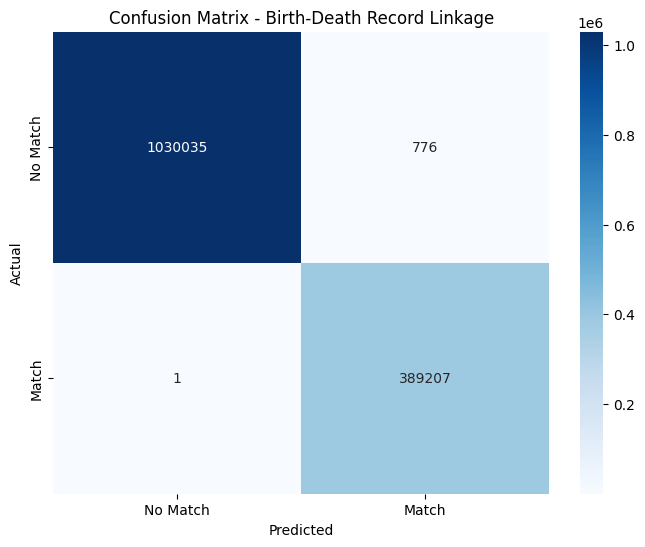


Top 10 Most Important Features:
                    feature  importance
24          age_consistency    0.235140
15       mother_forename_jw    0.137276
17  mother_forename_jaccard    0.133839
16       mother_forename_dl    0.116748
11  father_forename_jaccard    0.098268
9        father_forename_jw    0.087423
10       father_forename_dl    0.067502
18        mother_surname_jw    0.016986
20   mother_surname_jaccard    0.013370
19        mother_surname_dl    0.013288


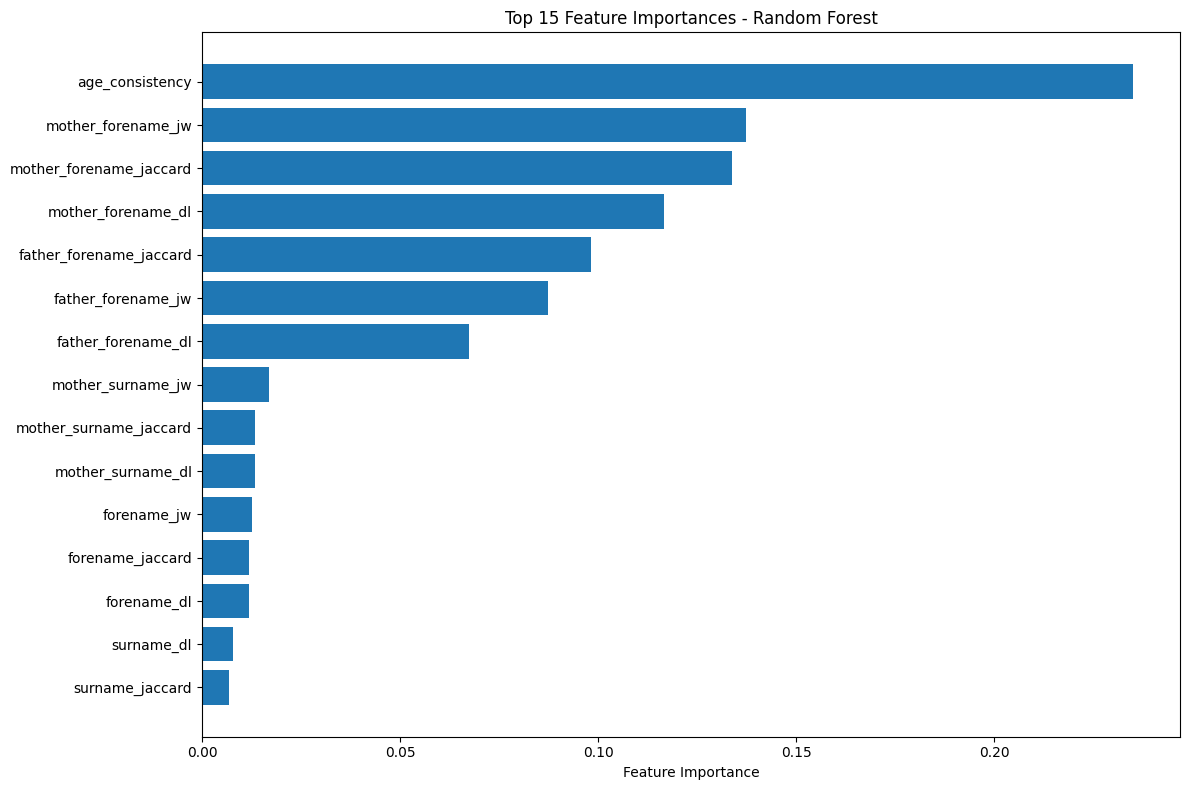

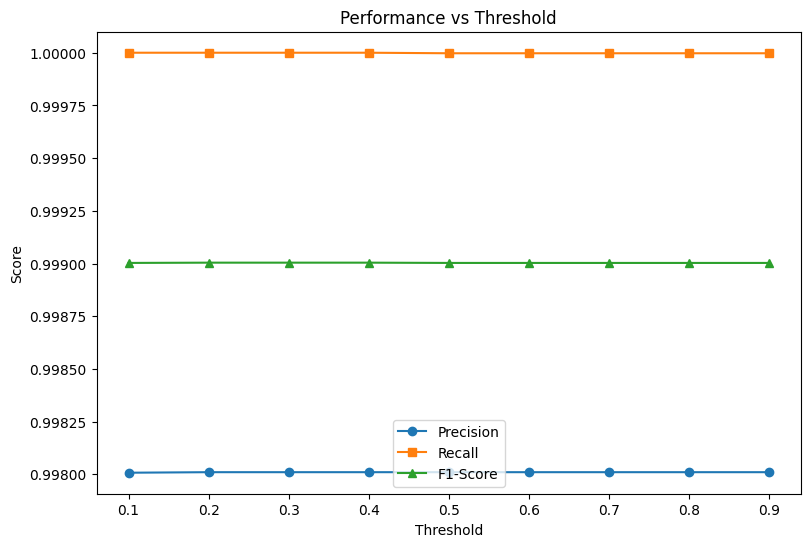


Cross-Validation Summary:
5-Fold Stratified Cross-Validation Results:
Precision: 0.9981 (+/- 0.0001)
Recall: 1.0000 (+/- 0.0000)
F1: 0.9991 (+/- 0.0000)

Final Model Performance on Test Set:
Total record pairs evaluated: 4733394
Actual matches in test set: 389208
Predicted matches in test set: 389983
True positives: 389207
False positives: 776
False negatives: 1
True negatives: 1030035

Test Set Performance:
Precision: 0.9980
Recall: 1.0000
F1-Score: 0.9990

Sample predictions:
   birth_id  death_id  actual_label  predicted_label  prediction_probability
0   1985265   1985265             1                1                0.999048
1   1883535   1909103             0                0                0.000000
2   1542655   1542655             1                1                0.999021
3   2174362    656578             0                0                0.000000
4    814836    726686             0                0                0.000000
5   1169733   1631601             0                0  

In [15]:

# %% [markdown]
# ## Step 5: Evaluation

# %%
# Calculate metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classification Results:")
print("=" * 30)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# %%
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(cm)

# Detailed classification report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# %%
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Match', 'Match'],
            yticklabels=['No Match', 'Match'])
plt.title('Confusion Matrix - Birth-Death Record Linkage')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# %%
# Feature importance analysis
feature_names = []
string_cols = ['forename', 'surname', 'sex', 'father_forename', 'father_surname', 
               'mother_forename', 'mother_surname', 'address']

for col in string_cols:
    feature_names.extend([f'{col}_jw', f'{col}_dl', f'{col}_jaccard'])
feature_names.append('age_consistency')

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10))

# %%
# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)

thresholds = np.arange(0.1, 1.0, 0.1)
precisions = []
recalls = []
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int) 
    # the cutoff point of pred_proba to know what probabilities should we say "this is a match"
    if np.sum(y_pred_thresh) > 0:
        precisions.append(precision_score(y_test, y_pred_thresh))
        recalls.append(recall_score(y_test, y_pred_thresh))
        f1_scores.append(f1_score(y_test, y_pred_thresh))
    else:
        precisions.append(0)
        recalls.append(0)
        f1_scores.append(0)

plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='s')
plt.plot(thresholds, f1_scores, label='F1-Score', marker='^')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Performance vs Threshold')
plt.legend()
# plt.grid(True)

# plt.tight_layout()
plt.show()

# %%
# Summary statistics
print("\nCross-Validation Summary:")
print("=" * 50)
print("5-Fold Stratified Cross-Validation Results:")
for metric in metrics:
    test_scores = cv_results[f'test_{metric}']
    print(f"{metric.capitalize()}: {test_scores.mean():.4f} (+/- {test_scores.std() * 2:.4f})")

print("\nFinal Model Performance on Test Set:")
print("=" * 50)
print(f"Total record pairs evaluated: {len(candidate_pairs)}")
print(f"Actual matches in test set: {np.sum(y_test)}")
print(f"Predicted matches in test set: {np.sum(y_pred)}")
print(f"True positives: {cm[1,1]}")
print(f"False positives: {cm[0,1]}")
print(f"False negatives: {cm[1,0]}")
print(f"True negatives: {cm[0,0]}")
print(f"\nTest Set Performance:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# %%

# Sample prediction results
# Save results with correct candidate pairs alignment
pairs_test_array = np.array(pairs_test)

results_df = pd.DataFrame({
    'birth_id': pairs_test_array[:, 0],          
    'death_id': pairs_test_array[:, 1],
    'actual_label': y_test,
    'predicted_label': y_pred,
    'prediction_probability': y_pred_proba
})
print(f"\nSample predictions:")
print(results_df.head(10))

print("=" * 80)

# view the inside data of FP that we missed
false_positives = results_df[(results_df['actual_label'] == 0) & 
                            (results_df['predicted_label'] == 1)]

print(f"\nTotal False Positives: {len(false_positives)}")

if len(false_positives) > 0:
    fp_sorted = false_positives.sort_values('prediction_probability', ascending=False)
    print(f"Top 10 False Positives:")
    print(fp_sorted.head(10).to_string(index=False))
else:
    print("🎉 No False Positives!")

print("=" * 80)

# view the inside data of FN that we missed
false_negative = results_df[(results_df['actual_label'] == 1) & 
                            (results_df['predicted_label'] == 0)]

print(f"\nTotal False Negatives: {len(false_negative)}")

if len(false_negative) > 0:
    fn_sorted = false_negative.sort_values('prediction_probability', ascending=False)
    print(f"Top 10 False Negatives:")
    print(fn_sorted.head(10).to_string(index=False))
else:
    print("🎉 No False Negatives!")

# Active Learning (500k dataset version)
- approx. 1.3 M rows

## Preparing data

In [16]:
# %%
# Active Learning with modAL
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling, entropy_sampling, margin_sampling
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

print("Starting Active Learning with modAL...")
print("=" * 50)

# %%
# Prepare data for active learning
print("Preparing data for active learning...")

# Use the same train/test split but treat training data as "unlabeled pool"
X_pool = X_train.copy()  # Pool of unlabeled data
y_pool = y_train.copy()         # True labels (hidden from learner initially)
X_test_al = X_test.copy()  # Test set remains the same
y_test_al = y_test.copy()



print(f"Pool size: {len(X_pool)} samples")
print(f"Test size: {len(X_test_al)} samples")
print(f"Pool positive ratio: {np.sum(y_pool)/len(y_pool):.4f}")

# %%
# Initialize with small labeled set
initial_labeled_size = 10  # Start with only 10 labeled samples
n_queries = 100             # Number of AL iterations

# Randomly select initial labeled samples (stratified)
initial_indices = []
for class_label in [0, 1]:
    class_indices = np.where(y_pool == class_label)[0] # find position of that particular class
    n_samples = initial_labeled_size // 2  # 5 samples per class
    np.random.seed(42)
    selected = np.random.choice(class_indices, size=n_samples, replace=False) # select the position in random
    initial_indices.extend(selected)

initial_indices = np.array(initial_indices)

# Split into initial labeled and remaining unlabeled
X_initial = X_pool[initial_indices]
y_initial = y_pool[initial_indices]

# Remove initial samples from pool
# give us the indices that are in the full range of X_pool BUT NOT in initial_indices
remaining_indices = np.setdiff1d(range(len(X_pool)), initial_indices) 
X_unlabeled = X_pool[remaining_indices]
y_unlabeled_true = y_pool[remaining_indices]  # True labels (hidden)

print(f"Initial labeled set: {len(X_initial)} samples")
print(f"Remaining unlabeled pool: {len(X_unlabeled)} samples")
print(f"Initial positive ratio: {np.sum(y_initial)/len(y_initial):.4f}")


Starting Active Learning with modAL...
Preparing data for active learning...
Pool size: 3313375 samples
Test size: 1420019 samples
Pool positive ratio: 0.2741
Initial labeled set: 10 samples
Remaining unlabeled pool: 3313365 samples
Initial positive ratio: 0.5000


In [17]:
X_initial[5]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.61862674, 0.23214286, 0.        , 0.5       ])

In [18]:
y_initial

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

## Set Model and see initial result

In [19]:

# %%
# Initialize Active Learner
print("Initializing Active Learner...")

# Use Random Forest as base estimator
rf_al = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_split=4,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced'
)

# Create Active Learner with uncertainty sampling
learner = ActiveLearner(
    estimator=rf_al,
    query_strategy=uncertainty_sampling,
    X_training=X_initial,
    y_training=y_initial
)

print("Active Learner initialized!")
print(f"Query strategy: uncertainty sampling")

# %%
# Active Learning Loop
print(f"\nStarting Active Learning Loop...")
print("=" * 40)

# Track performance metrics
al_results = {
    'n_labeled': [],
    'test_accuracy': [],
    'test_precision': [],
    'test_recall': [],
    'test_f1': [],
    'pool_size': []
}

# Evaluate initial performance
y_pred_initial = learner.predict(X_test_al)

initial_accuracy = accuracy_score(y_test_al, y_pred_initial)
initial_precision = precision_score(y_test_al, y_pred_initial, zero_division=0)
initial_recall = recall_score(y_test_al, y_pred_initial, zero_division=0)
initial_f1 = f1_score(y_test_al, y_pred_initial, zero_division=0)

print(f"Initial performance (with {len(X_initial)} samples):")
print(f"  Accuracy: {initial_accuracy:.4f}")
print(f"  Precision: {initial_precision:.4f}")
print(f"  Recall: {initial_recall:.4f}")
print(f"  F1-Score: {initial_f1:.4f}")

# Store initial results
al_results['n_labeled'].append(len(X_initial))
al_results['test_accuracy'].append(initial_accuracy)
al_results['test_precision'].append(initial_precision)
al_results['test_recall'].append(initial_recall)
al_results['test_f1'].append(initial_f1)
al_results['pool_size'].append(len(X_unlabeled))


Initializing Active Learner...
Active Learner initialized!
Query strategy: uncertainty sampling

Starting Active Learning Loop...
Initial performance (with 10 samples):
  Accuracy: 0.9670
  Precision: 0.8925
  Recall: 1.0000
  F1-Score: 0.9432


## Active Learning Iteration
- we do another 20 loop iterations
- 1 loop per 1 data point

In [20]:
# Active learning iterations
for iteration in range(n_queries):
    print(f"\nIteration {iteration + 1}/{n_queries}")
    print("-" * 30)
    
    # Check if we still have unlabeled samples
    if len(X_unlabeled) == 0:
        print("No more unlabeled samples!")
        break
        
    # Query the most uncertain sample
    query_idx, query_instance = learner.query(X_unlabeled, n_instances=1)
    
    # Get model's prediction probability BEFORE teaching
    pred_proba = learner.predict_proba(query_instance.reshape(1, -1))[0]
    uncertainty = 1 - np.max(pred_proba)  # Uncertainty measure
    match_probability = pred_proba[1] * 100  # Probability of match (class 1) as percentage
    no_match_probability = pred_proba[0] * 100  # Probability of no match (class 0) as percentage
    
    # Get the true label for the queried sample (simulate human labeling)
    true_label = y_unlabeled_true[query_idx[0]]


    # ================================
    # TRACK QUERY HISTORY
    # ================================
    
    
    # Teach the learner with the new labeled sample
    learner.teach(query_instance, [true_label])
    
    # **** The reason why the var is changed all the time is it's delete as soon as the learner is taught
    # Remove the queried sample from unlabeled pool
    X_unlabeled = np.delete(X_unlabeled, query_idx[0], axis=0)
    y_unlabeled_true = np.delete(y_unlabeled_true, query_idx[0], axis=0)
    
    # Evaluate current performance
    y_pred_current = learner.predict(X_test_al)
    current_accuracy = accuracy_score(y_test_al, y_pred_current)
    current_precision = precision_score(y_test_al, y_pred_current, zero_division=0)
    current_recall = recall_score(y_test_al, y_pred_current, zero_division=0)
    current_f1 = f1_score(y_test_al, y_pred_current, zero_division=0)
    
    # Store results
    current_labeled = len(X_initial) + iteration + 1
    al_results['n_labeled'].append(current_labeled)
    al_results['test_accuracy'].append(current_accuracy)
    al_results['test_precision'].append(current_precision)
    al_results['test_recall'].append(current_recall)
    al_results['test_f1'].append(current_f1)
    al_results['pool_size'].append(len(X_unlabeled))
    
    # Enhanced progress display with uncertainty and probabilities
    print(f"Labeled samples: {current_labeled}")
    print(f"Pool remaining: {len(X_unlabeled)}")
    print(f"Queried label: {true_label} {'(MATCH)' if true_label == 1 else '(NO MATCH)'}")
    print(f"Model uncertainty: {uncertainty:.4f}")
    print(f"Match probability: {match_probability:.2f}%")
    print(f"No-match probability: {no_match_probability:.2f}%")
    print(f"Current F1: {current_f1:.4f}")

print("\nActive Learning completed!")


Iteration 1/100
------------------------------
Labeled samples: 11
Pool remaining: 3313364
Queried label: 0 (NO MATCH)
Model uncertainty: 0.4999
Match probability: 50.01%
No-match probability: 49.99%
Current F1: 0.9382

Iteration 2/100
------------------------------
Labeled samples: 12
Pool remaining: 3313363
Queried label: 0 (NO MATCH)
Model uncertainty: 0.5000
Match probability: 50.00%
No-match probability: 50.00%
Current F1: 0.9431

Iteration 3/100
------------------------------
Labeled samples: 13
Pool remaining: 3313362
Queried label: 0 (NO MATCH)
Model uncertainty: 0.4999
Match probability: 50.01%
No-match probability: 49.99%
Current F1: 0.9432

Iteration 4/100
------------------------------
Labeled samples: 14
Pool remaining: 3313361
Queried label: 0 (NO MATCH)
Model uncertainty: 0.5000
Match probability: 50.00%
No-match probability: 50.00%
Current F1: 0.9439

Iteration 5/100
------------------------------
Labeled samples: 15
Pool remaining: 3313360
Queried label: 0 (NO MATCH)


In [21]:
features = X_unlabeled[query_idx]       # Feature vector
label = y_unlabeled_true[query_idx]     # True label
# pair = pairs_unlabeled[query_idx]
print(f"\nQueried Feature Vector: {features}")
print(f"Queried True Label: {label}")   


Queried Feature Vector: [[1.         1.         1.         0.4537037  0.11111111 0.
  1.         1.         1.         0.         0.2        0.
  0.4537037  0.11111111 0.         0.56190476 0.28571429 0.
  0.42592593 0.11111111 0.         0.60233074 0.24528302 0.
  0.01333333]]
Queried True Label: [0]


## Plot Graph and Result

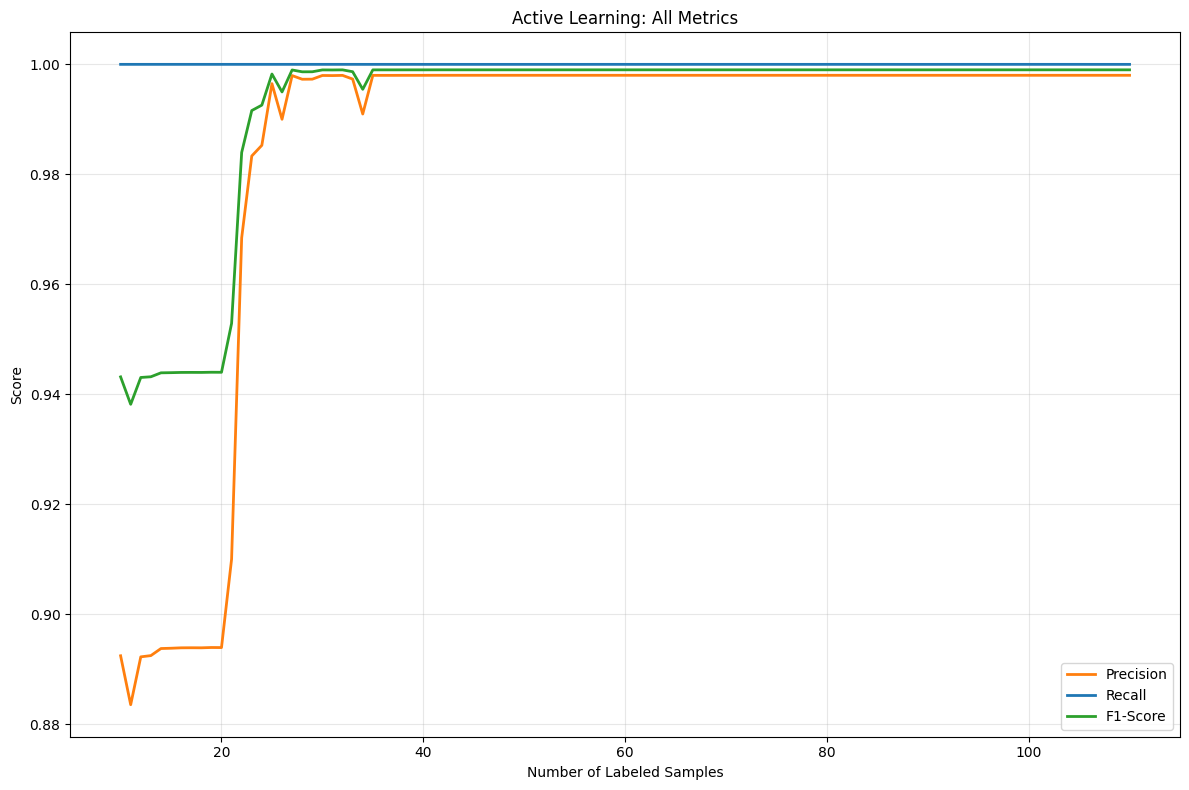

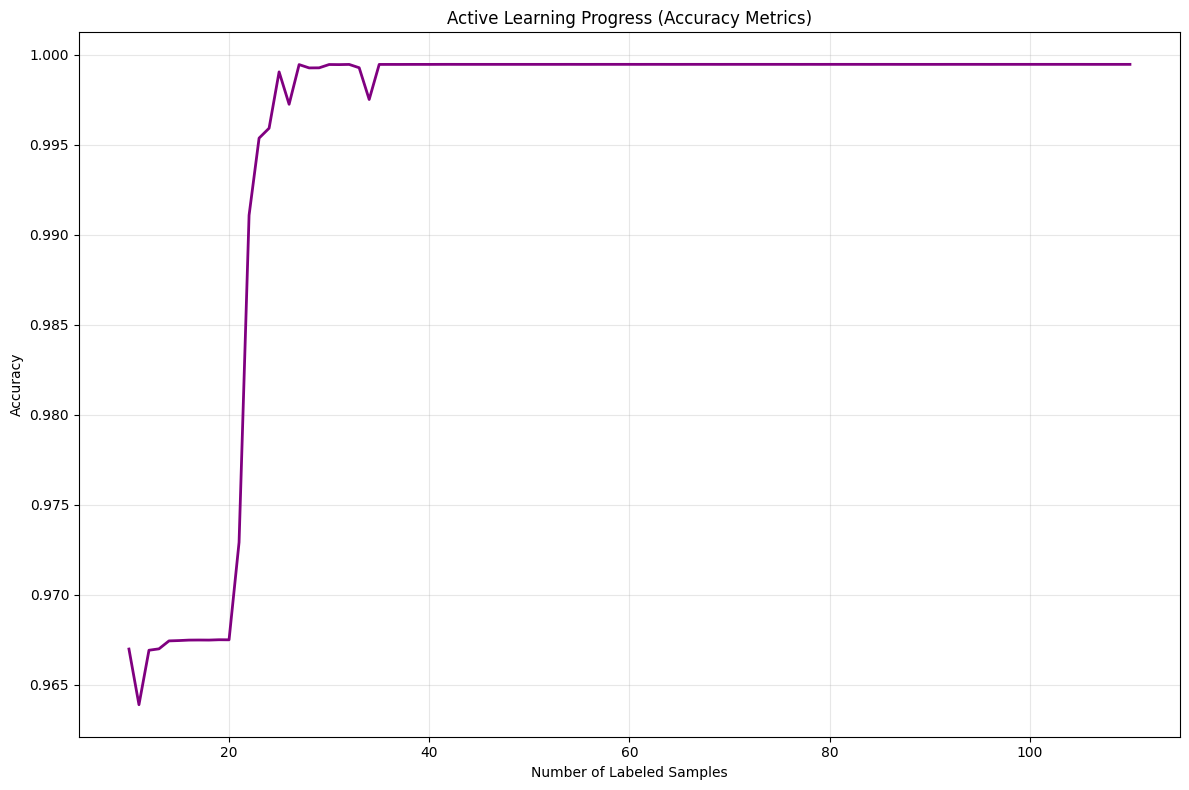


Active Learning Summary:
Initial labeled samples: 10
Final labeled samples: 110
Total queries made: 100

Performance Improvement:
Initial F1-Score: 0.9432
Final F1-Score: 0.9990
F1 Improvement: 0.0558

Final Performance:
Precision: 0.9980
Recall: 1.0000
F1-Score: 0.9990
Accuracy: 0.9995

Active Learning Progress Table:
 n_labeled  test_accuracy  test_precision  test_recall  test_f1  pool_size
        10       0.966972        0.892456     1.000000 0.943172    3313365
        11       0.963879        0.883560     1.000000 0.938181    3313364
        12       0.966905        0.892261     1.000000 0.943064    3313363
        13       0.966983        0.892489     1.000000 0.943190    3313362
        14       0.967424        0.893774     1.000000 0.943908    3313361
        15       0.967443        0.893827     1.000000 0.943937    3313360
        16       0.967469        0.893903     1.000000 0.943980    3313359
        17       0.967473        0.893915     1.000000 0.943987    3313358
   

In [25]:

# %%
# Plot Active Learning Results

# Start a new figure and set its overall size
plt.figure(figsize=(12, 8)) # As requested: 20 inches wide, 6 inches tall

# Define the first subplot (1 row, 2 columns, this is the 1st plot)
# plt.subplot(1, 2, 1) # This makes the 'All Metrics' plot the left one

# Plot 2: All Metrics vs Number of Labeled Samples
# Directly use plt.plot, plt.xlabel, etc., as plt.subplot sets the current active axes
plt.plot(al_results['n_labeled'], al_results['test_precision'],
                marker='o', markersize=0, label='Precision', linewidth=2, color='#FF7F0E') # Orange
plt.plot(al_results['n_labeled'], al_results['test_recall'],
                marker='s', markersize=0, label='Recall', linewidth=2, color='#1F77B4')    # Blue
plt.plot(al_results['n_labeled'], al_results['test_f1'],
                marker='^', markersize=0, label='F1-Score', linewidth=2, color='#2CA02C')  # Green
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Score')
plt.title('Active Learning: All Metrics')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Define the second subplot (1 row, 2 columns, this is the 2nd plot)
# plt.subplot(1, 2, 2) # This makes the 'Accuracy' plot the right one
plt.figure(figsize=(12, 8))
# Plot 3: Accuracy vs Number of Labeled Samples
# Directly use plt.plot, plt.xlabel, etc., for this subplot
plt.plot(al_results['n_labeled'], al_results['test_accuracy'],
                marker='o', label='Accuracy', linewidth=2, markersize=0, color='purple') # Teal
plt.xlabel('Number of Labeled Samples')
plt.ylabel('Accuracy')
plt.title('Active Learning Progress (Accuracy Metrics)')
plt.grid(True, alpha=0.3)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()


# %%
# Summary of Active Learning Results
print(f"\nActive Learning Summary:")
print("=" * 30)
print(f"Initial labeled samples: {al_results['n_labeled'][0]}")
print(f"Final labeled samples: {al_results['n_labeled'][-1]}")
print(f"Total queries made: {len(al_results['n_labeled']) - 1}")

print(f"\nPerformance Improvement:")
print(f"Initial F1-Score: {al_results['test_f1'][0]:.4f}")
print(f"Final F1-Score: {al_results['test_f1'][-1]:.4f}")
print(f"F1 Improvement: {al_results['test_f1'][-1] - al_results['test_f1'][0]:.4f}")

print(f"\nFinal Performance:")
print(f"Precision: {al_results['test_precision'][-1]:.4f}")
print(f"Recall: {al_results['test_recall'][-1]:.4f}")
print(f"F1-Score: {al_results['test_f1'][-1]:.4f}")
print(f"Accuracy: {al_results['test_accuracy'][-1]:.4f}")

# %%
# Create results dataframe for analysis
al_results_df = pd.DataFrame(al_results)
print(f"\nActive Learning Progress Table:")
print(al_results_df.to_string(index=False))

### Plot graph (Further detail)


Active Learning Summary:
Initial labeled samples: 10
Final labeled samples: 110
Total queries made: 100

Performance Improvement:
Initial F1-Score: 0.9432
Final F1-Score: 0.9990
F1 Improvement: 0.0558

Final Performance:
Precision: 0.9980
Recall: 1.0000
F1-Score: 0.9990
Accuracy: 0.9995

FINAL MODEL EVALUATION WITH CONFUSION MATRIX


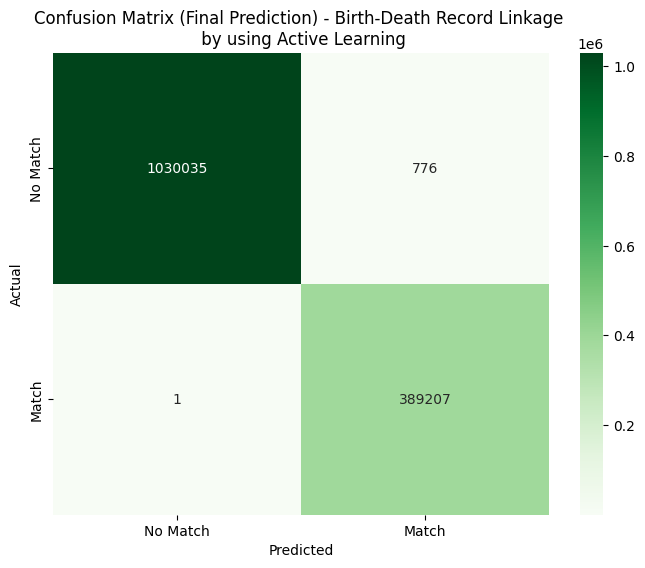


DETAILED CONFUSION MATRIX ANALYSIS:
---------------------------------------------

PERFORMANCE METRICS:
Sensitivity (Recall):   100.00% - % of true matches found
Specificity:             99.92% - % of true non-matches found
Precision:               99.80% - % of predicted matches that are correct
Accuracy:                99.95% - Overall correctness
F1-Score:                99.90% - Harmonic mean of precision and recall

CLASSIFICATION REPORT:
---------------------------------------------
              precision    recall  f1-score   support

    No Match     1.0000    0.9992    0.9996   1030811
       Match     0.9980    1.0000    0.9990    389208

    accuracy                         0.9995   1420019
   macro avg     0.9990    0.9996    0.9993   1420019
weighted avg     0.9995    0.9995    0.9995   1420019


ACTIVE LEARNING EFFICIENCY ANALYSIS:
---------------------------------------------

RECORD LINKAGE INTERPRETATION:
---------------------------------------------
• True Matches F

In [23]:

# %%
# Summary of Active Learning Results
print(f"\nActive Learning Summary:")
print("=" * 30)
print(f"Initial labeled samples: {al_results['n_labeled'][0]}")
print(f"Final labeled samples: {al_results['n_labeled'][-1]}")
print(f"Total queries made: {len(al_results['n_labeled']) - 1}")
print(f"\nPerformance Improvement:")
print(f"Initial F1-Score: {al_results['test_f1'][0]:.4f}")
print(f"Final F1-Score: {al_results['test_f1'][-1]:.4f}")
print(f"F1 Improvement: {al_results['test_f1'][-1] - al_results['test_f1'][0]:.4f}")
print(f"\nFinal Performance:")
print(f"Precision: {al_results['test_precision'][-1]:.4f}")
print(f"Recall: {al_results['test_recall'][-1]:.4f}")
print(f"F1-Score: {al_results['test_f1'][-1]:.4f}")
print(f"Accuracy: {al_results['test_accuracy'][-1]:.4f}")

# %%
# CONFUSION MATRIX AND FINAL EVALUATION
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("\n" + "="*60)
print("FINAL MODEL EVALUATION WITH CONFUSION MATRIX")
print("="*60)

# Get final predictions
y_pred_final = learner.predict(X_test_al)
y_pred_proba_final = learner.predict_proba(X_test_al)

# Create confusion matrix
cm = confusion_matrix(y_test_al, y_pred_final)

# %%
# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['No Match', 'Match'],
            yticklabels=['No Match', 'Match'])
plt.title('Confusion Matrix (Final Prediction) - Birth-Death Record Linkage ' \
    '\n by using Active Learning')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# %%
# Detailed Confusion Matrix Analysis
print("\nDETAILED CONFUSION MATRIX ANALYSIS:")
print("-" * 45)

tn, fp, fn, tp = cm.ravel()


print(f"\nPERFORMANCE METRICS:")
specificity = tn/(tn+fp) if (tn+fp) > 0 else 0
sensitivity = tp/(tp+fn) if (tp+fn) > 0 else 0
precision = tp/(tp+fp) if (tp+fp) > 0 else 0
accuracy = (tp+tn)/(tp+tn+fp+fn)
f1 = 2*(precision*sensitivity)/(precision+sensitivity) if (precision+sensitivity) > 0 else 0

print(f"Sensitivity (Recall):   {sensitivity*100:6.2f}% - % of true matches found")
print(f"Specificity:            {specificity*100:6.2f}% - % of true non-matches found")
print(f"Precision:              {precision*100:6.2f}% - % of predicted matches that are correct")
print(f"Accuracy:               {accuracy*100:6.2f}% - Overall correctness")
print(f"F1-Score:               {f1*100:6.2f}% - Harmonic mean of precision and recall")

# Classification Report
print(f"\nCLASSIFICATION REPORT:")
print("-" * 45)
report = classification_report(y_test_al, y_pred_final, 
                             target_names=['No Match', 'Match'], 
                             digits=4)
print(report)

# %%
# Active Learning Efficiency Analysis
print(f"\nACTIVE LEARNING EFFICIENCY ANALYSIS:")
print("-" * 45)

initial_f1 = al_results['test_f1'][0]
final_f1 = al_results['test_f1'][-1]
improvement = final_f1 - initial_f1
samples_used = al_results['n_labeled'][-1]
initial_samples = al_results['n_labeled'][0]
additional_samples = samples_used - initial_samples


print(f"\nRECORD LINKAGE INTERPRETATION:")
print("-" * 45)
print(f"• True Matches Found:     {tp}/{tp+fn} ({tp/(tp+fn)*100:.1f}% recall)")
print(f"• False Links Created:    {fp} (linking different people)")
print(f"• Missed True Matches:    {fn} (same person not linked)")
print(f"• Correct Non-Matches:    {tn} (different people correctly separated)")

if fp > fn:
    print(f"→ Model tends to be more aggressive (creates some false links)")
elif fn > fp:
    print(f"→ Model tends to be more conservative (misses some true matches)")
else:
    print(f"→ Model has balanced error types")

print(f"\nActive Learning analysis completed!")
print("="*60)